In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data(filename : str) -> pd.DataFrame:
    # tyto konstanty nemente, pomuzou vam pri nacitani
    headers = ["p1", "p36", "p37", "p2a", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13a",
                "p13b", "p13c", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24", "p27", "p28",
                "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a",
                "p57", "p58", "a", "b", "d", "e", "f", "g", "h", "i", "j", "k", "l", "n", "o", "p", "q", "r", "s", "t", "p5a"]

    #def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    regions = {
        "PHA": "00",
        "STC": "01",
        "JHC": "02",
        "PLK": "03",
        "ULK": "04",
        "HKK": "05",
        "JHM": "06",
        "MSK": "07",
        "OLK": "14",
        "ZLK": "15",
        "VYS": "16",
        "PAK": "17",
        "LBK": "18",
        "KVK": "19",
    }
    regions_swap = {value: key for key, value in regions.items()}
    print(regions_swap)
    with zipfile.ZipFile(filename, 'r') as zf:
        # print(zf.namelist())
        # zf.printdir()
        df = pd.DataFrame()
        for x in zf.namelist():
            inner_zip = zipfile.ZipFile(zf.open(x))
            for csv_file in inner_zip.namelist():
                if csv_file.split('.')[0] not in regions.values():  # 08 - 13 empty, skiping them
                    continue
                csv = inner_zip.open(csv_file) # 'a'?
                df_temp = pd.read_csv(csv, sep=';', names=headers, encoding='cp1250', low_memory=False)
                df_temp['region'] = regions_swap[csv_file.split('.')[0]]
                df = pd.concat([df, df_temp], ignore_index=True)
    return df


# dfx = load_data('data.zip')

In [3]:

def load_data(filename : str) -> pd.DataFrame:
    # tyto konstanty nemente, pomuzou vam pri nacitani
    headers = ["p1", "p36", "p37", "p2a", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13a",
                "p13b", "p13c", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24", "p27", "p28",
                "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a",
                "p57", "p58", "a", "b", "d", "e", "f", "g", "h", "i", "j", "k", "l", "n", "o", "p", "q", "r", "s", "t", "p5a"]

    #def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    regions = {
        "PHA": "00",
        "STC": "01",
        "JHC": "02",
        "PLK": "03",
        "ULK": "04",
        "HKK": "05",
        "JHM": "06",
        "MSK": "07",
        "OLK": "14",
        "ZLK": "15",
        "VYS": "16",
        "PAK": "17",
        "LBK": "18",
        "KVK": "19",
    }
    regions_swap = {value: key for key, value in regions.items()}

    def read_append(csv):
        df = pd.read_csv(csv, sep=';', names=headers, encoding='cp1250', low_memory=False)
        df['region'] = regions_swap[csv.name.split('.')[0]]
        return df

    with zipfile.ZipFile(filename, 'r') as zf:
        # print(zf.namelist())
        # zf.printdir()
        df = pd.DataFrame()
        for year_zip in zf.namelist():
            inner_zip = zipfile.ZipFile(zf.open(year_zip))
            csv_list = list(map(inner_zip.open, inner_zip.namelist()))
            csv_list = [x for x in csv_list if x.name.split('.')[0] in regions.values()]
            # dff = pd.concat(map(lambda x: pd.read_csv(x, sep=';', names=headers, encoding='cp1250', low_memory=False), csv_list), ignore_index=True)
            df_temp = pd.concat([read_append(x) for x in  csv_list], ignore_index=True)
            df = pd.concat([df, df_temp], ignore_index=True)

    return df


df = load_data('data.zip')


In [28]:
def parse_data(df : pd.DataFrame, verbose : bool = False) -> pd.DataFrame:
    df_new = df.copy()
    df_new = df_new.drop_duplicates(subset=['p1'])
    df_new['date'] = pd.to_datetime(df_new["p2a"])
    df_new['date'] = df_new['date'].dt.strftime('%Y-%m-%d')
    df_new['p2a'] = pd.to_datetime(df_new["p2a"]) # ???
    # df_new = df_new.astype({"p": str, 't': str}) # e,d with comma, convert to dot and to float, q mixed float and str?
    for x in 'abdefgo':
        df_new[x] = df_new[x].str.replace(',','.')
        df_new[x] = pd.to_numeric(df_new[x], errors='coerce')
    df_new['n'] = pd.to_numeric(df_new['n'], errors='coerce')

    for x in df_new.columns:
        if df_new.dtypes.loc[x] == 'int64' and df_new[x].max() < 127 and df_new[x].min() > -127:
            df_new[x] = df_new[x].astype('int8')
    for x in 'pqhi':
        df_new[x] = df_new[x].astype('category')

    print(df_new['p2a'].unique())
    print(df_new['date'].unique())
    # print(type(df_new.loc[0,'e']))
    # print(df_new['p19'])
    # print(df_new['h'].unique())
    # print(df_new['i'].unique())
    # print(df_new.dtypes[10:25])
    # print(df_new.max(numeric_only=True))
    # print(df_new.min(numeric_only=True))
    # print(df_new.max())

    # dff = pd.DataFrame(df_new.dtypes)
    # dff['max'] = df_new.max()
    # dff['min'] = df_new.min()
    # with pd.option_context('display.max_rows', None,
    #                    'display.max_columns', None,
    #                    'display.precision', 3,
    #                    ):
    #     print(dff)
    # print(df_new.info(verbose=True, memory_usage='deep'))
    if verbose:
        orig_size = df.memory_usage(deep=True).sum()/10**6
        new_size = df_new.memory_usage(deep=True).sum()/10**6
        print(f"orig_size={orig_size:0.1f} MB")
        print(f"new_size={new_size:0.1f} MB")
    return df_new

df_new = parse_data(df, verbose=True)
df_new


['2016-01-01T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-03T00:00:00.000000000' ... '2021-12-29T00:00:00.000000000'
 '2021-12-30T00:00:00.000000000' '2021-12-31T00:00:00.000000000']
['2016-01-01' '2016-01-02' '2016-01-03' ... '2021-12-29' '2021-12-30'
 '2021-12-31']
orig_size=941.4 MB
new_size=413.9 MB


,p1,p36,p37,p2a,weekday(p2a),p2b,p6,p7,p8,p9,...,n,o,p,q,r,s,t,p5a,region,date
0,2100160001,4,NaN,2016-01-01,5,55,1,1,0,2,...,711403.0,NaN,Souhlasnýsesměremúseku,Pomalý,554782.0,451622.0,GN_V0.1UIR-ADR_410,1,PHA,2016-01-01
1,2100160002,4,NaN,2016-01-01,5,130,1,3,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
2,2100160003,5,NaN,2016-01-01,5,100,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
3,2100160004,6,NaN,2016-01-01,5,120,9,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
4,2100160005,6,NaN,2016-01-01,5,2560,2,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609145,190906210729,2,606.0,2021-12-27,1,1040,9,0,0,2,...,1760003.0,NaN,Opačnýkesměruúseku,Pomalý,560294.0,NaN,GN_V0.1UIR-ADR_410,2,KVK,2021-12-27
609146,190906210730,6,NaN,2021-12-28,2,905,2,0,0,2,...,798429.0,NaN,Souhlasnýsesměremúseku,Pomalý,560499.0,552101.0,GN_V0.1UIR-ADR_410,1,KVK,2021-12-28
609147,190906210731,6,NaN,2021-12-30,4,350,3,0,3,2,...,734801.0,NaN,Opačnýkesměruúseku,Pomalý,560286.0,553824.0,GN_V0.1UIR-ADR_410,1,KVK,2021-12-30
609148,190906210732,6,NaN,2021-12-30,4,1035,2,0,0,2,...,1459025.0,NaN,Opačnýkesměruúseku,Pomalý,560286.0,553476.0,GN_V0.1UIR-ADR_410,1,KVK,2021-12-30


  region             p19     p1
0    HKK  den-nezhorsena  19019
1    HKK    den-zhorsena   2906
2    HKK  noc-nezhorsena   7298
3    HKK    noc-zhorsena    731
   region             p19     p1
28    PAK  den-nezhorsena  16370
29    PAK    den-zhorsena   1908
30    PAK  noc-nezhorsena   6160
31    PAK    noc-zhorsena    385
48    VYS  den-nezhorsena  14750
49    VYS    den-zhorsena   3464
50    VYS  noc-nezhorsena   7871
51    VYS    noc-zhorsena   1017


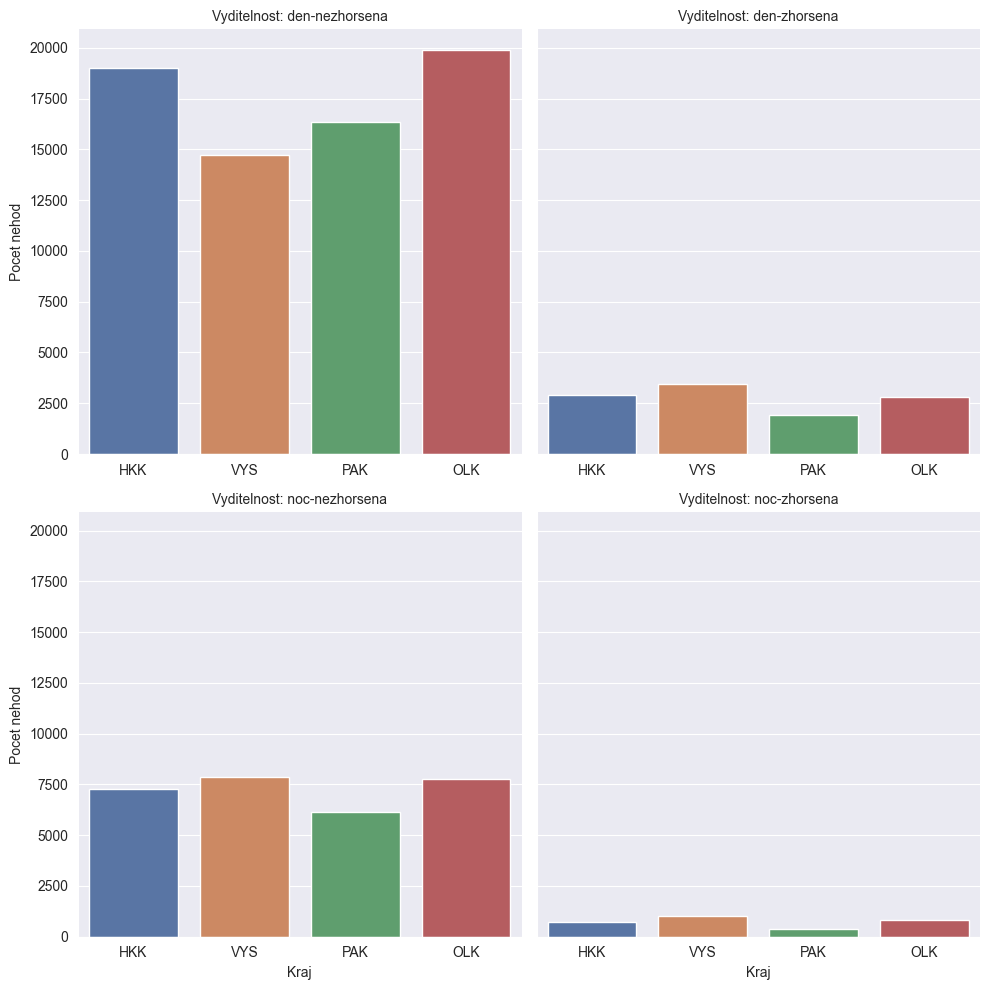

In [13]:

def plot_visibility(df: pd.DataFrame, fig_location: str = None, show_figure: bool = False):
    df = df.copy()
    # den: zhorsena-2,3 | nezhorsena-1
    # noc: zhorsena-5,7 | nezhorsena-4,6
    df.loc[df['p19'] == 1, 'p19'] = 'den-nezhorsena'
    df.loc[(df['p19'] == 2) | (df['p19'] == 3), 'p19'] = 'den-zhorsena'
    df.loc[(df['p19'] == 4) | (df['p19'] == 6), 'p19'] = 'noc-nezhorsena'
    df.loc[(df['p19'] == 5) | (df['p19'] == 7), 'p19'] = 'noc-zhorsena'
    # print(df.groupby('region').count()['p19'])
    table = pd.pivot_table(df, values='p1', index=['region', 'p19'], aggfunc="count").reset_index()
    print(table[table['region'] == 'HKK'])
    print(table[(table['region'] == "VYS") | (table['region'] == "PAK")])
    sns.set_style("darkgrid")
    sns.set_palette('deep')
    # g = sns.catplot(x='region', data=df, col='p19', col_wrap=2, kind='count', order=['HKK', 'VYS', 'PAK', 'OLK'], sharex=False)
    g = sns.catplot(x='region', y='p1', data=table, col='p19', col_wrap=2, kind='bar', order=['HKK', 'VYS', 'PAK', 'OLK'], sharex=False)
    g.set_axis_labels('Kraj', 'Pocet nehod')
    g.set_titles("Vyditelnost: {col_name}")
    if fig_location:
        g.savefig(fig_location)
    if show_figure:
        plt.show()

plot_visibility(df_new)

    region  months      p7   p1
0      HKK       1   bocni  457
1      HKK       1   celni  107
2      HKK       1  zezadu  201
3      HKK       2   bocni  340
4      HKK       2   celni   79
..     ...     ...     ...  ...
499    ZLK      11   celni   62
500    ZLK      11  zezadu  122
501    ZLK      12   bocni  250
502    ZLK      12   celni   65
503    ZLK      12  zezadu   99

[504 rows x 4 columns]


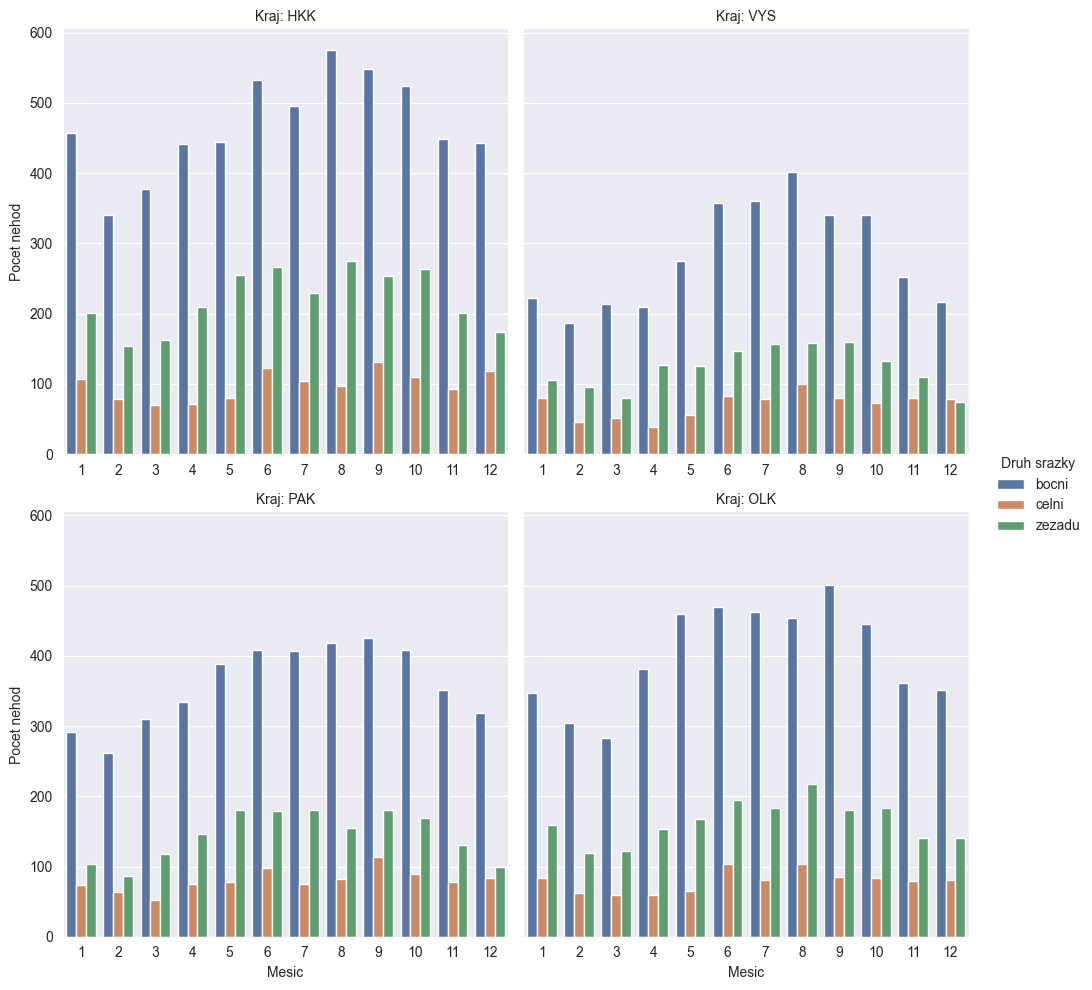

In [27]:
def plot_direction(df: pd.DataFrame, fig_location: str = None, show_figure: bool = False):
    df = df.copy()
    # print(df.groupby('p7').count()['p1'])
    df = df.drop(df[df['p7'] == 0].index) # deleting rows with 0
    df.loc[df['p7'] == 1, 'p7'] = 'celni'
    df.loc[(df['p7'] == 2) | (df['p7'] == 3), 'p7'] = 'bocni'
    df.loc[df['p7'] == 4, 'p7'] = 'zezadu'
    df['months'] = df['p2a'].dt.month
    table = pd.pivot_table(data=df, values='p1', index=['region', 'months', 'p7'], aggfunc='count').reset_index()
    print(table)
    sns.set_style("darkgrid")
    # g = sns.catplot(data=df, x='months', kind='count', hue='p7', col='region', col_order=['HKK', 'VYS', 'PAK', 'OLK'], col_wrap=2, sharex=False)
    g = sns.catplot(data=table, x='months', y='p1', kind='bar', hue='p7', col='region', col_order=['HKK', 'VYS', 'PAK', 'OLK'], col_wrap=2, sharex=False, legend_out=True)
    g.set_titles("Kraj: {col_name}")
    g._legend.set_title('Druh srazky')
    g.set_axis_labels('Mesic', 'Pocet nehod')
    g.tight_layout()
    if show_figure:
        plt.show()
    if fig_location:
        g.savefig(fig_location)
    
plot_direction(df_new)

           p2a region variable  value
0   2016-01-01    HKK     p13a      1
1   2016-01-01    OLK     p13a      1
2   2016-01-01    PAK     p13a      4
3   2016-01-01    VYS     p13a      2
4   2016-02-01    HKK     p13a      4
..         ...    ...      ...    ...
859 2021-11-01    VYS     p13c     84
860 2021-12-01    HKK     p13c     91
861 2021-12-01    OLK     p13c     77
862 2021-12-01    PAK     p13c    102
863 2021-12-01    VYS     p13c     95

[864 rows x 4 columns]


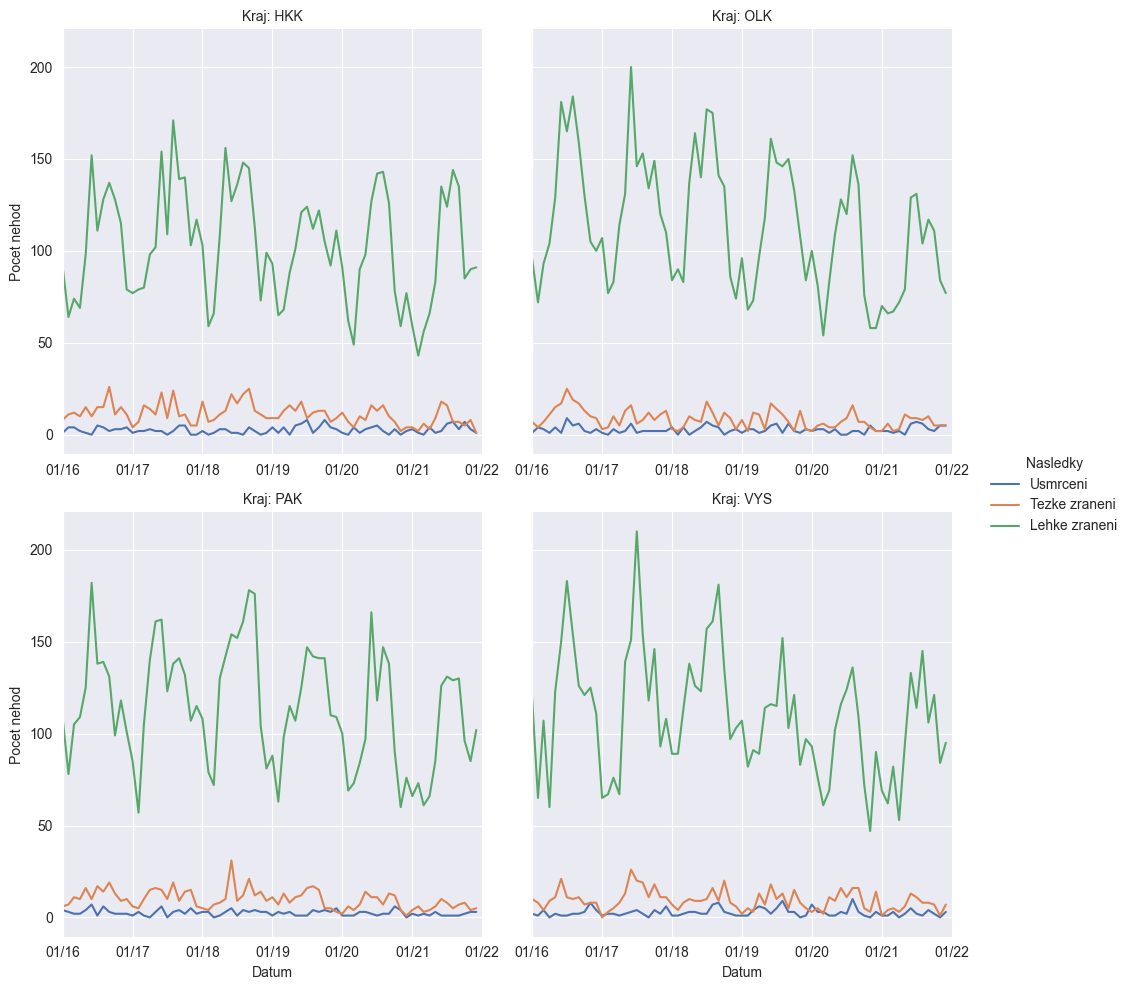

In [38]:
def plot_consequences(df: pd.DataFrame, fig_location: str = None, show_figure: bool = False):
    df = df.copy()
    # print(df['region'].value_counts()[['HKK', 'VYS', 'PAK', 'OLK']])
    df= df[df['region'].isin(['HKK', 'VYS', 'PAK', 'OLK'])]
    # df['p2a'] = pd.to_datetime(df["p2a"], format="%Y%m")
    df['p2a'] = pd.to_datetime(df["p2a"].dt.strftime('%Y-%m'))
    # print(df['p2a'])
    table = pd.pivot_table(df, values=['p13a', 'p13b', 'p13c'], index=['p2a','region'], aggfunc=np.sum)
    table = pd.melt(table.reset_index(), id_vars=['p2a', 'region'], value_vars=['p13a', 'p13b', 'p13c'])
    print(table)
    sns.set_style("darkgrid")
    sns.set_palette("deep")
    facet_kws={'sharey': True, 'sharex': False, 'legend_out': True}
    g = sns.relplot(data=table, x='p2a', y='value', kind='line', col='region', col_wrap=2, hue='variable', facet_kws=facet_kws)
    g._legend.set_title("Nasledky")
    sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5))
    for t, l in zip(g._legend.texts, ['Usmrceni', 'Tezke zraneni', 'Lehke zraneni']):
        t.set_text(l)

    g.set_axis_labels('Datum', 'Pocet nehod')
    g.set_titles("Kraj: {col_name}")
    # print(ax.axes_dict['HKK'].get_xticks())
    g.set_xticklabels([f'01/{x}' for x in range(15,23)])
    g.set(xlim=(pd.to_datetime("20160101", format='%Y%m%d'), pd.to_datetime("20220101", format='%Y%m%d')))
    g.tight_layout()
    if show_figure:
        plt.show()
    if fig_location:
        g.savefig(fig_location)

plot_consequences(df_new)

In [8]:
weigths1 = ['number of features(number of neurons in)', 'number of neurons out']